# Retrieval metrics with different embeddings
- flags
- positions
- positions + angles + ratio
- positions normalized
- positions normalized + angles + ratio

**Load the dataset**

In [ ]:
%load_ext autoreload
%autoreload 2

from embeddings import EmbeddingBuilder
import os
import ipynbname
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

from retrieval import ImageRetrieval
from classifier import Classifier
import file_manager
import file_manager

project_dir = f"{os.getcwd().split('SIDS_revelation_project')[0]}SIDS_revelation_project/"
image_dataset_path = f"{project_dir}datasets/onback_onstomach_v3"
model_path = f"{project_dir}/models/4.weights/best.pt"

In [17]:
emb_builder = EmbeddingBuilder(model_path, image_dataset_path, "load")


Extracting dataset info from .coco.json file:---------------------------------------------
Dataset contains 4158 valid samples, and labels are {'baby_on_back': 1, 'baby_on_stomach': 2}
------------------------------------------------------------------------------------------

Loading features from .csv----------------------------------------------------------------
Features loaded succesfully, in particular there are 4158 files in the dataset
------------------------------------------------------------------------------------------

Embedding builder initialized successfully------------------------------------------------
Face detection model: 4 (YOLOv8)
Dataset: /Users/lorenzodimaio/Download/SIDS_revelation_project/datasets/onback_onstomach_v3
Dataset dimension: 4158
Dataset labels: {'baby_safe': 0, 'baby_unsafe': 1}
------------------------------------------------------------------------------------------


In [18]:
print(f"Dataset contains {emb_builder.dim_dataset} elements.\nIn particular {emb_builder.dim_dataset-emb_builder.y.sum()} {'baby_safe' if emb_builder.classes_bs['baby_safe'] == 0 else 'baby_unsafe'} and {emb_builder.y.sum()} {'baby_safe' if emb_builder.classes_bs['baby_safe'] == 1 else 'baby_unsafe'}")

Dataset contains 4158 elements.
In particular 2146 baby_safe and 2012 baby_unsafe


**Create embeddings**

In [19]:
e_flags = emb_builder.create_embedding(flags = True)
e_positions = emb_builder.create_embedding(flags = True, positions=True)
e_positions_norm = emb_builder.create_embedding(flags = True, positions_normalized=True)
e_all_unnorm = emb_builder.create_embedding(flags = True, positions=True, geometric_info=True)
e_all_norm = emb_builder.create_embedding(flags = True, positions_normalized = True, geometric_info=True)
e_all = emb_builder.create_embedding(flags = True, positions = True, positions_normalized=True, geometric_info=True)


Embedding creation------------------------------------------------------------------------
Features: ['flag_eye1', 'flag_eye2', 'flag_nose', 'flag_mouth']
FINISHED: 4158 embedding created
------------------------------------------------------------------------------------------

Embedding creation------------------------------------------------------------------------
Features: ['flag_eye1', 'flag_eye2', 'flag_nose', 'flag_mouth', 'x_eye1', 'y_eye1', 'x_eye2', 'y_eye2', 'x_nose', 'y_nose', 'x_mouth', 'y_mouth']
FINISHED: 4158 embedding created
------------------------------------------------------------------------------------------

Embedding creation------------------------------------------------------------------------
Features: ['flag_eye1', 'flag_eye2', 'flag_nose', 'flag_mouth', 'x_eye1_norm', 'y_eye1_norm', 'x_eye2_norm', 'y_eye2_norm', 'x_nose_norm', 'y_nose_norm', 'x_mouth_norm', 'y_mouth_norm']
FINISHED: 4158 embedding created
-----------------------------------------------

**Initialize retrieval metrics**

In [5]:
ret_flags = ImageRetrieval(e_flags, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
ret_positions = ImageRetrieval(e_positions, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
ret_positions_norm = ImageRetrieval(e_positions_norm, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
ret_all_unnomr =ImageRetrieval(e_all_unnorm, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
ret_all_norm =ImageRetrieval(e_all_norm, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)
ret_all =ImageRetrieval(e_all, emb_builder.y, emb_builder.image_paths, image_dataset_path, emb_builder.classes_bs)

ret_flags.build_index()
ret_positions.build_index()
ret_positions_norm.build_index()
ret_all_unnomr.build_index()
ret_all_norm.build_index()
ret_all.build_index()

In [6]:
figsize = ret_flags.figsize
colors = ["blue", "green", "red", "purple", "orange", "brown"]

k_values = [5, 10, 20, 50]
precision_scores = {
    "Flags" : ret_flags.plot_precision_at_k(k_values=k_values, verbose=False),
    "Positions": ret_positions.plot_precision_at_k(k_values=k_values, verbose=False), 
    "Positions Norm":ret_positions_norm.plot_precision_at_k(k_values=k_values, verbose=False), 
    "All Unnorm" :ret_all_unnomr.plot_precision_at_k(k_values=k_values, verbose=False),
    "All norm":ret_all_norm.plot_precision_at_k(k_values=k_values, verbose=False), 
    "All features":ret_all.plot_precision_at_k(k_values=k_values, verbose=False)
}
print("Precision scores evaluated succesfully!")

silhouette_scores = {
    "Flags" : ret_flags.plot_silhouette_per_class(),
    "Positions": ret_positions.plot_silhouette_per_class(), 
    "Positions Norm":ret_positions_norm.plot_silhouette_per_class(), 
    "All Unnorm" :ret_all_unnomr.plot_silhouette_per_class(),
    "All norm":ret_all_norm.plot_silhouette_per_class(), 
    "All features":ret_all.plot_silhouette_per_class()
}
print("silhouette scores evaluated succesfully!")

recallR_scores = {
    "Flags" : ret_flags.recall_at_R(),
    "Positions": ret_positions.recall_at_R(), 
    "Positions Norm":ret_positions_norm.recall_at_R(), 
    "All Unnorm" :ret_all_unnomr.recall_at_R(),
    "All norm":ret_all_norm.recall_at_R(), 
    "All features":ret_all.recall_at_R()
}
print("RecallR scores evaluated succesfully!")


Precision scores evaluated succesfully!
silhouette scores evaluated succesfully!
RecallR scores evaluated succesfully!


**Create plots**

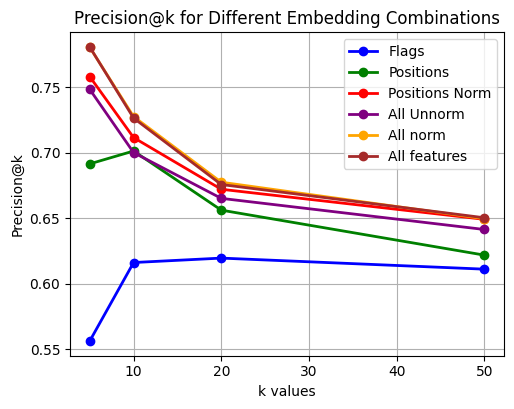

In [7]:
plt.figure(figsize=figsize)

for score, label, color in zip(precision_scores.values(), precision_scores.keys(), colors):
    plt.plot(k_values, score, marker="o", color=color, linewidth=2, label=label)

# Legenda
plt.legend()
plt.xlabel("k values")
plt.ylabel("Precision@k")
plt.title("Precision@k for Different Embedding Combinations")
plt.grid(True)
plt.show()

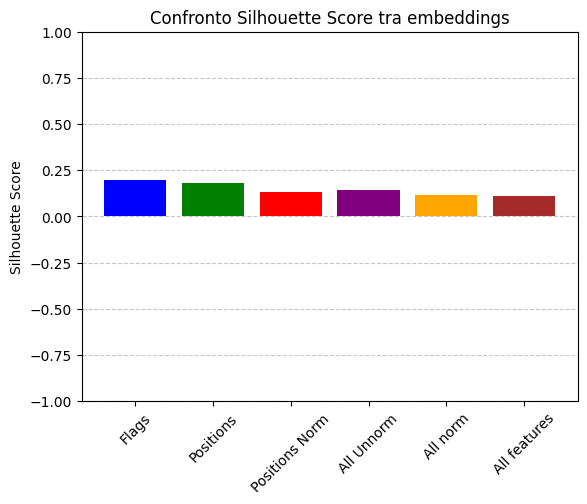

In [8]:
plt.bar(silhouette_scores.keys(), silhouette_scores.values(), color=colors)
plt.ylabel("Silhouette Score")
plt.title("Confronto Silhouette Score tra embeddings")
plt.xticks(rotation=45)
plt.ylim(-1,1)  # silhouette score è tra -1 e 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

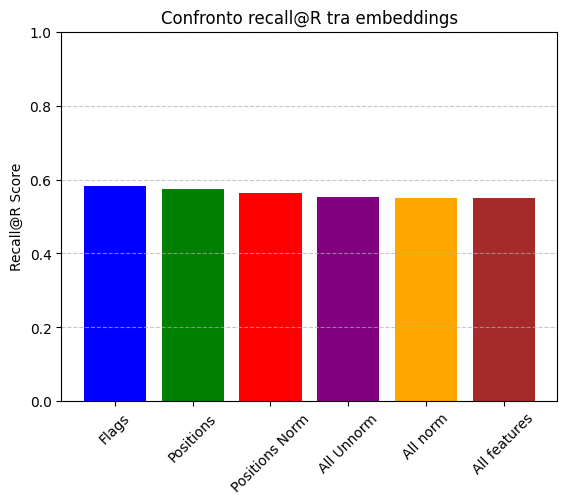

In [9]:
plt.bar(recallR_scores.keys(), recallR_scores.values(), color=colors)
plt.ylabel("Recall@R Score")
plt.title("Confronto recall@R tra embeddings")
plt.xticks(rotation=45)
plt.ylim(0,1)  # silhouette score è tra -1 e 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Prepare training**

In [10]:
cls_flag = Classifier(e_flags, emb_builder.y, emb_builder.classes_bs)
cls_positions = Classifier(e_positions, emb_builder.y, emb_builder.classes_bs)
cls_positions_norm = Classifier(e_positions_norm, emb_builder.y, emb_builder.classes_bs)
cls_all_unnorm = Classifier(e_all_unnorm, emb_builder.y, emb_builder.classes_bs)
cls_all_norm= Classifier(e_all_norm, emb_builder.y, emb_builder.classes_bs)
cls_all = Classifier(e_all, emb_builder.y, emb_builder.classes_bs)

clf = RandomForestClassifier(n_estimators=300,
                max_depth=8,              # limit tree depth
                min_samples_split=10,     # require more samples to split
                min_samples_leaf=5,       # require more samples per leaf
                max_features="sqrt",      # random feature selection
                bootstrap=True,
                random_state=42)

In [11]:
learning_scores = {
    "Flags" : cls_flag.plot_learning_curve(clf, verbose = False),
    "Positions": cls_positions.plot_learning_curve(clf, verbose = False), 
    "Positions Norm":cls_positions_norm.plot_learning_curve(clf, verbose = False), 
    "All Unnorm" :cls_all_unnorm.plot_learning_curve(clf, verbose = False),
    "All norm":cls_all_norm.plot_learning_curve(clf, verbose = False), 
    "All features":cls_all.plot_learning_curve(clf, verbose = False)
}
print("Learning scores evaluated succesfully!")

/opt/anaconda3/envs/yolov8_env/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/yolov8_env/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/anaconda3/envs/yolov8_env/lib/python3.10/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this pack

Learning scores evaluated succesfully!


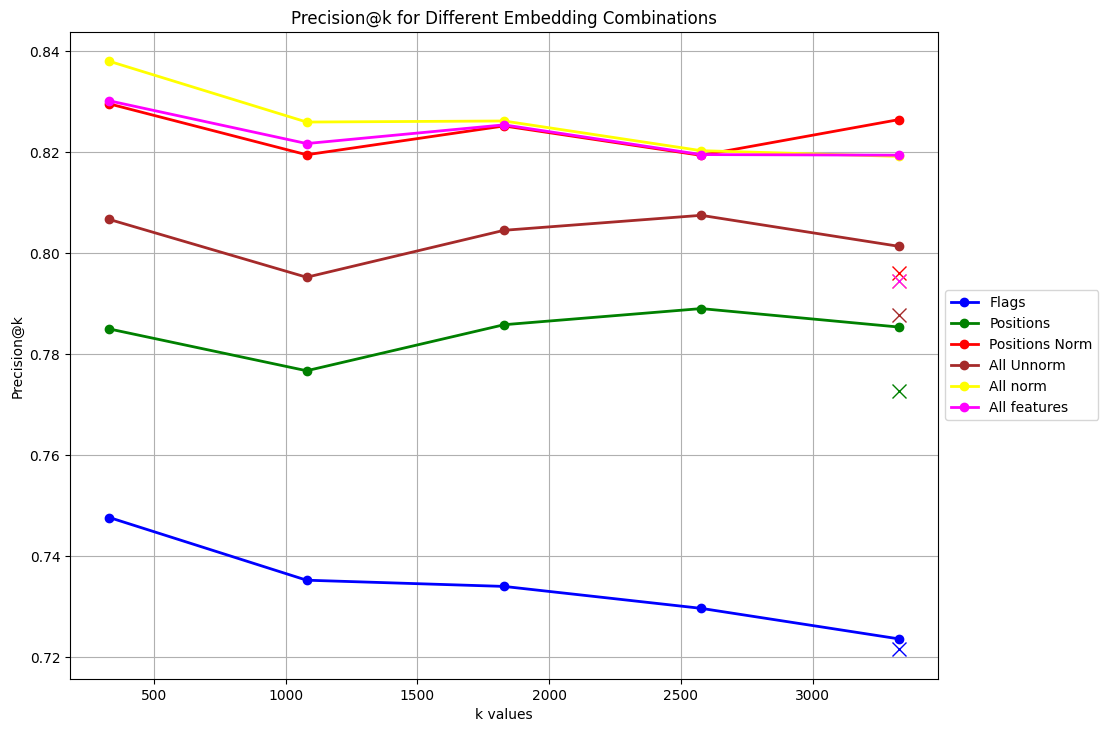

In [12]:
figsize = (cls_flag.figsize[0]*2, cls_flag.figsize[1]*2)
colors = ["blue", "green", "red", "brown", "yellow", "fuchsia"]

plt.figure(figsize=figsize)
for score, label, color in zip(learning_scores.values(), learning_scores.keys(), colors):
    plt.plot(score[0], score[3], marker="o", color=color, linewidth=2, label=label)
    #plt.plot(score[0], score[4], marker="o", color=color, linewidth=2, label=label) test curve
    plt.plot(score[0][len(score[0])-1], score[4][len(score[4])-1], marker="x",markersize = 10, color=color)

# Legenda
plt.legend(
    loc="center left",          # posizione di riferimento
    bbox_to_anchor=(1, 0.5),    # sposta la legenda a destra del grafico
    fontsize=10
)
plt.xlabel("k values")
plt.ylabel("Precision@k")
plt.title("Precision@k for Different Embedding Combinations")
plt.grid(True)
plt.show()

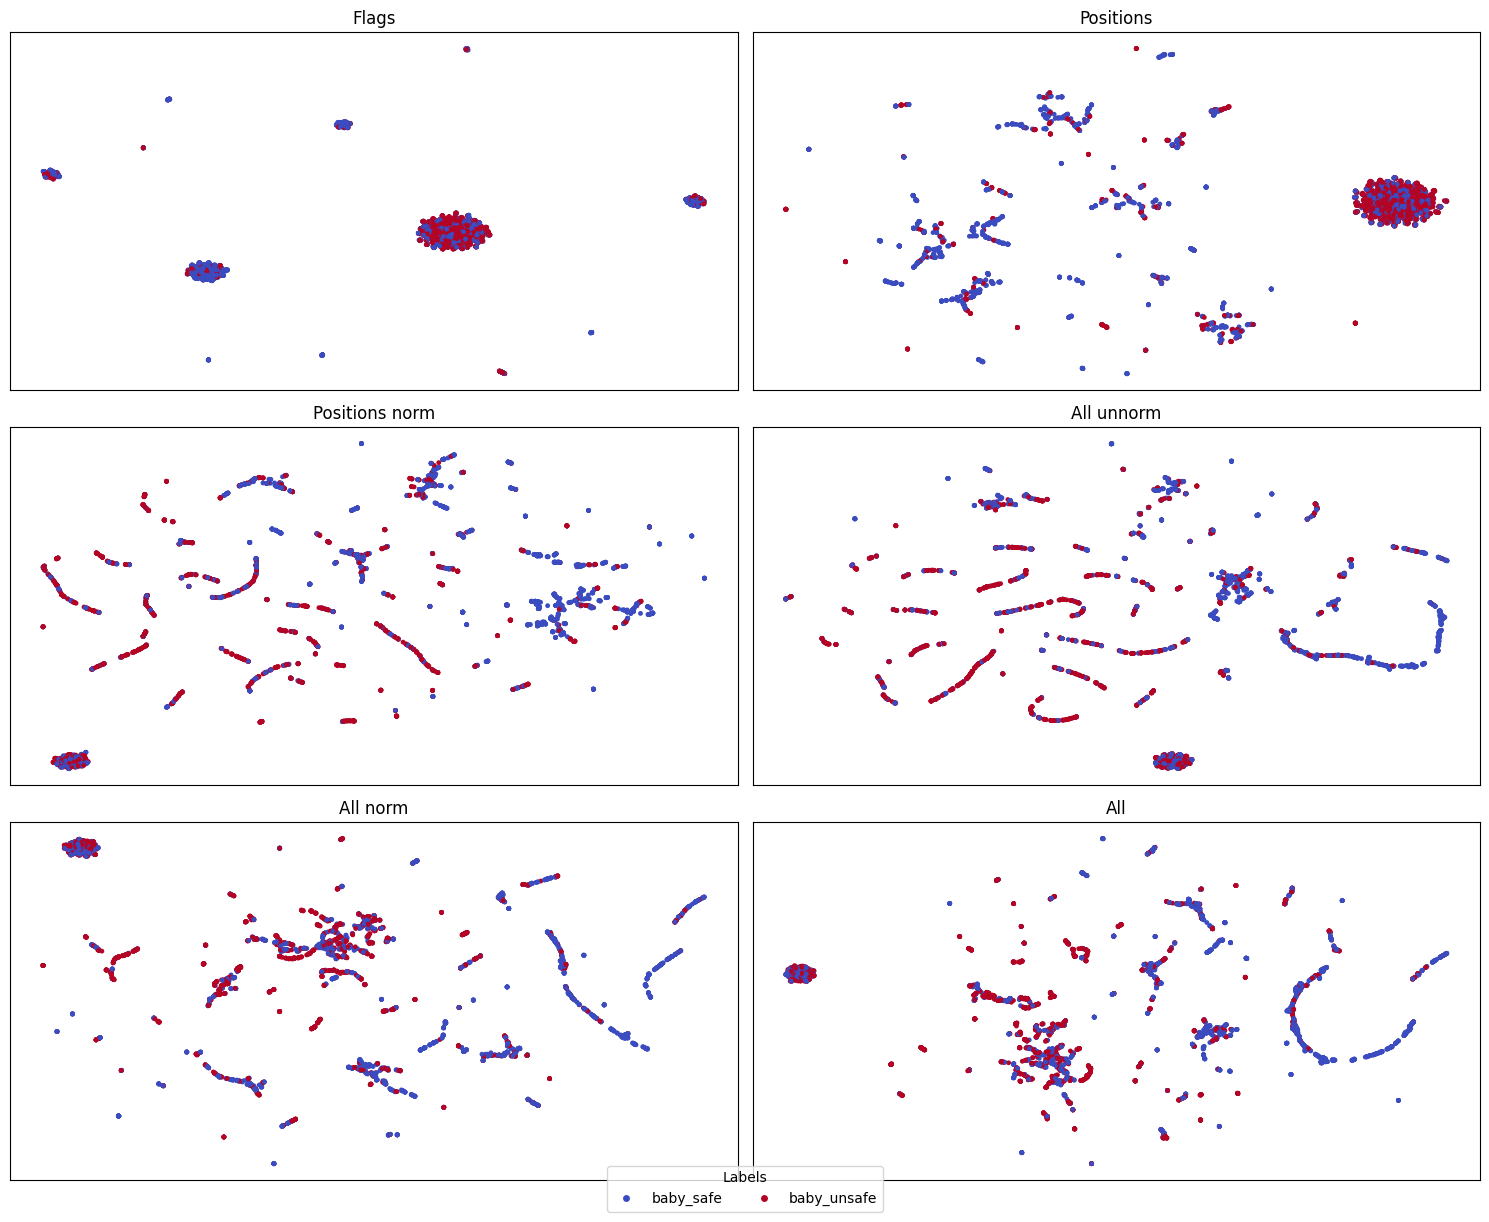

In [13]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import umap
import warnings

warnings.filterwarnings("ignore")

# Lista di embeddings e nomi
embeddings_list = [ret_flags.embeddings_norm, ret_positions.embeddings_norm, ret_positions_norm.embeddings_norm, ret_all_unnomr.embeddings_norm, ret_all_norm.embeddings_norm, ret_all.embeddings_norm]
embedding_names = ["Flags", "Positions", "Positions norm", "All unnorm", "All norm", "All"]
labels = ret_flags.labels
classes = ret_flags.classes_bs

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
cmap = plt.colormaps["coolwarm"].resampled(2)

for ax, emb, name in zip(axes.ravel(), embeddings_list, embedding_names):
    # UMAP
    reducer = umap.UMAP(n_components=2, random_state=42)
    proj = reducer.fit_transform(emb)
    
    # Scatter
    ax.scatter(proj[:,0], proj[:,1], c=labels, s=6, cmap=cmap)
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

# Crea una sola legenda usando i nomi delle classi
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(label_idx), markersize=6, label=label_name)
    for label_name, label_idx in classes.items()
]

# Posizioniamo la legenda centralmente sotto tutti i subplot
fig.legend(handles=legend_elements, title="Labels", loc="lower center", ncol=len(classes), bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.show()

# Show Images

['2460_png_jpg.rf.7e7dedbe50b96b8c1da6a09294db1b50.jpg', '2460_png_jpg.rf.a43368ef498891e2b6ab5a7033fa171d.jpg', '1962_png_jpg.rf.1b8f9045deea22f3ef8fd9c83f0e5565.jpg', '2021_png_jpg.rf.544db04f99a26b3d3a26249ff1179430.jpg', '2392_png_jpg.rf.150e8573db05826eeb4fbe199fa011ad.jpg']


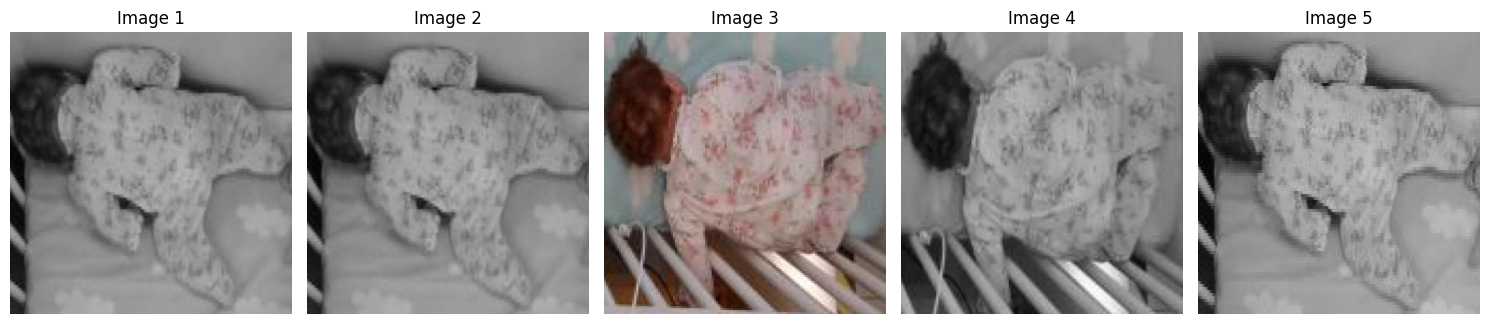

In [14]:
distances_all, image_paths_similar_all = ret_all.retrieve_similar(idx_query=0,k=5,verbose=False,external_embeddings=True,external_embd=ret_all.embeddings_norm[0].reshape(1,-1))
print(image_paths_similar_all)
ret_all.show_images(image_paths_similar_all,)

In [15]:
file_manager.save_as_pdf(ipynbname.path())

[NbConvertApp] Converting notebook /Users/lorenzodimaio/Download/SIDS_revelation_project/full_pipeline/dataset_v3_retrieval.ipynb to pdf
[NbConvertApp] Support files will be in /Users/lorenzodimaio/Download/SIDS_revelation_project/full_pipeline/reports/dataset_v3_retrieval(2025-09-01)_files/
[NbConvertApp] Writing 64869 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 679832 bytes to /Users/lorenzodimaio/Download/SIDS_revelation_project/full_pipeline/reports/dataset_v3_retrieval(2025-09-01).pdf
